In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [4]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-wpw3adf5
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-wpw3adf5
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


In [5]:
%load_ext nvcc_plugin

directory /notebooks/src already exists
Out bin /notebooks/result.out


In [14]:
%%cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <math.h> 
#include "cuda.h"
#include <iostream>
#include <chrono>
#include <cassert>

using namespace std;
using namespace std::chrono;

const int NUM_ELEMENTS = 1 << 20;
const int THREADS_PER_BLOCK = 128;
const int NUM_OPERATIONS = 1;
const float MAXERROR = 0.001;
float* d_A = NULL;
float* d_C = NULL;

// Device functions
__global__ void vectorAdd(const float* A, float* C) {
	__shared__ float sdata[THREADS_PER_BLOCK];
	unsigned int tid = threadIdx.x;
	unsigned int i = blockIdx.x * (blockDim.x * 2) + threadIdx.x;
	sdata[tid] = A[i] + A[i + blockDim.x];
	__syncthreads();
    
	// Reduction in shared mem
	for(unsigned int s = blockDim.x / 2; s > 0; s >>= 1) {
		if (tid < s) {
			sdata[tid] += sdata[tid + s];
		}
		__syncthreads();
	}
    
	// Write result for this block to global mem
	if(tid == 0) C[blockIdx.x] = sdata[0];
	__syncthreads();
}

int calculateThreads(int iteration) {
	int result = NUM_ELEMENTS;
	for (int i = 1; i < iteration; i++) {
		result /= (THREADS_PER_BLOCK * 2);
	}
	return result/2;
}

float gpu_vector_sum(float *vector, float *red_vector, const int n) {
    size_t size = n * sizeof(float);
    
    // Allocate cuda memory
	cudaMalloc((void**)& d_A, size);
	cudaMalloc((void**)& d_C, size);

	int kernel_execs = 0, b_base = 1;
	while (b_base < NUM_ELEMENTS) {
		b_base *= THREADS_PER_BLOCK * 2;
		kernel_execs++;
	}
	printf("Количество проходов Kernel: %d\n", kernel_execs);

	cudaMemcpy(d_A, vector, size, cudaMemcpyHostToDevice);

	int blocks = -1;
	int elements = n;
	for (int i = 0; i < kernel_execs; i++) {
		int blocks = ceil(elements / (THREADS_PER_BLOCK * 2.0));
		printf("Количество блоков: %d\n", blocks);
		vectorAdd << < blocks, THREADS_PER_BLOCK >> > (d_A, d_C);		
		cudaMemcpy(d_A, d_C, size, cudaMemcpyDeviceToDevice);
		if (i + 1 < kernel_execs) {
			cudaMemset(d_C, 0, size);
		}
		elements = blocks;
	}
    
    // Copy result to host memory
	cudaMemcpy(red_vector, d_C, size, cudaMemcpyDeviceToHost);
    
    // Dispose cuda memory
    cudaFree(d_A);
    cudaFree(d_C);
    return red_vector[0];
}

float cpu_vector_sum(float *vector, const int n) {
	float checkSum = 0;
	for (int i = 0; i < n; ++i) {
		checkSum += vector[i];
	}
    return checkSum;
}

void init_vector(float *vector, const int n) {
	for (int i = 0; i < n; ++i) {
		vector[i] = rand() / (float)RAND_MAX;
	}
}

int main(void) {
    size_t size = NUM_ELEMENTS * sizeof(float);
    printf("Суммируем вектор из %d элементов\n", NUM_ELEMENTS);

    // Allocate the host input vector A and C
    float* h_A = (float*)malloc(size);
    float* h_C = (float*)malloc(size); 
    
    // Initialize input vector
    init_vector(h_A,NUM_ELEMENTS);
    
    auto startCPU = high_resolution_clock::now();
    float cpuResult = cpu_vector_sum(h_A, NUM_ELEMENTS);
    auto stopCPU = high_resolution_clock::now();
    auto durationCPU = duration_cast<microseconds>(stopCPU - startCPU);
    
    auto startGPU = high_resolution_clock::now();
    float gpuResult =  gpu_vector_sum(h_A, h_C, NUM_ELEMENTS);
    auto stopGPU = high_resolution_clock::now();
    auto durationGPU = duration_cast<microseconds>(stopGPU - startGPU);
    
    assert(cpuResult - gpuResult < cpuResult * MAXERROR);
    cout << "CPU результат - " << cpuResult << endl;
    cout << "GPU результат - " << gpuResult << endl; 
    cout << "Время CPU функции: " << durationCPU.count() << " микросекунд" << endl;
    cout << "Время GPU функции: " << durationGPU.count() << " микросекунд" << endl;
    
    // Free host memory
    free(h_A);
    free(h_C);
	return 0;
}

Суммируем вектор из 1048576 элементов
Количество проходов Kernel: 3
Количество блоков: 4096
Количество блоков: 16
Количество блоков: 1
CPU результат - 524282
GPU результат - 524285
Время CPU функции: 3387 микросекунд
Время GPU функции: 170401 микросекунд



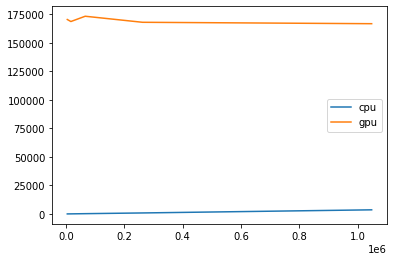

In [12]:
import matplotlib.pyplot as plt

cpu = [14, 56, 231, 863, 3599];
gpu = [170398, 168623, 173252, 167957, 166719];
size = [4096, 16384, 65536, 262144, 1048576];

fig, ax = plt.subplots()
ax.plot(size, cpu, label="cpu")
ax.plot(size, gpu, label="gpu")
ax.legend()

plt.show()

In [ ]:
Распараллеленно поблочное сложение элементов (в функции device сначала вектор уменьшаеться вдвое и далее в блоке циклом 
сокращаеться еще вдвое за каждый проход), внешний цикл проходит блоки. Данный алгоритм имеет низкую эффективность по 
сравнению с CPU функцией, так как она линейна по времени и имеет o(n) = n (числу элементов вектора), сложение CUDA требует 
затрат на работу с памятю, что в даном случае оказывает решающее значение.